## A. Importing Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('./bank.csv')

In [3]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

Task 1: Data Preparation Pipeline

Open a new Jupyter notebook and name it etivity2.ipynb. In this notebook, create a data preparation pipeline that applies the same kind of transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

In [4]:
categories = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'subscribed']

for category in categories:
    counts = df[category].value_counts(dropna=True)
    if counts.sum() < 2000:
        print("\n", counts, "Total: ",counts.sum())


 age
33.0    95
35.0    90
31.0    87
34.0    84
32.0    77
        ..
86.0     2
73.0     2
81.0     2
79.0     1
18.0     1
Name: count, Length: 68, dtype: int64 Total:  1988

 job
management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: count, dtype: int64 Total:  1990

 education
secondary    995
tertiary     684
primary      217
Name: count, dtype: int64 Total:  1896

 contact
cellular     1663
telephone     146
Name: count, dtype: int64 Total:  1809

 poutcome
failure    955
success    444
other      147
Name: count, dtype: int64 Total:  1546


We are missing values in five fields, my approach to each is:
- Age insert the median as the data is skewed
- Job and education insert unknown, there isn't much to go on really but could potentially look at correlations to other variables if we wanted best guesses rather than simply using unknown
- Contact I am dropping entirely as the data we do have is either celular or telephone (presumably landline) or missing. This is largely the same thing, older customers may be more likely to have landlines but we already have age so any dependency of target variable on age should be picked up directly rather than relying on some loosely correlated to age variable like landline versus mobile.
- poutcome the answer 'other' can cover a broad range of results so there is no need to have both unknown and other, I will fill in all blank variables with other.
- I also feel day and month of last contact are not useful. Similarly pdays feels like a proxy categorical variable as the -1 values are not really numeric, they mean the individual has never been contacted. The previous variable contains similar information on intensity of contact but is cleaner as people who were never contacted have a zero and the entire dataset is actually numeric with no awkward -1s etc. I am removing these fields to reduce compute times and reduce the chances we fit to noise.

In [5]:
df['age'].fillna(df['age'].median(), inplace=True)
df['job'].fillna('unknown', inplace=True)
df['education'].fillna('unknown', inplace=True)
df['poutcome'].fillna('other', inplace=True)

df.drop('contact', axis=1, inplace=True)
df.drop('day', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.drop('pdays', axis=1, inplace=True)
df.head()




age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

   duration  campaign  previous poutcome subscribed  
0       957         2         2  failure         no  
1       233         2         1  failure         no  
2       126         2         1  failure         no  
3       274         1         2  failure         no  
4       479         1         1  failure         no

Now I have filled in the missing values and dropped (hopefully) redundant info I need to tidy up the categorical variables. I will encode the binary categories as 0s and 1s and one hot encode those with more categories.

In [6]:
remainingCategories = ['job','marital','education','default','housing','loan','subscribed']

for category in remainingCategories:
    counts = df[category].value_counts(dropna=True)
    print("\n", counts, "Total: ",counts.sum())


 job
management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
unknown           10
Name: count, dtype: int64 Total:  2000

 marital
married     1111
single       674
divorced     215
Name: count, dtype: int64 Total:  2000

 education
secondary    995
tertiary     684
primary      217
unknown      104
Name: count, dtype: int64 Total:  2000

 default
no     1985
yes      15
Name: count, dtype: int64 Total:  2000

 housing
no     1037
yes     963
Name: count, dtype: int64 Total:  2000

 loan
no     1750
yes     250
Name: count, dtype: int64 Total:  2000

 subscribed
no     1000
yes    1000
Name: count, dtype: int64 Total:  2000


I wanted to handle the below within the main pipeline but when I do I get an error that columns aren't found in the data when they are clearly there. If I handle the below four outside the main pipeline it works. 

My code for attemppting to handle within pipeline is below.

In [ ]:
'''('binary_mapper', ColumnTransformer(
    transformers=[
        ('binary_mapping', FunctionTransformer(
            func=lambda X: X.replace({
                'default': {'no': 0, 'yes': 1},
                'housing': {'no': 0, 'yes': 1},
                'loan': {'no': 0, 'yes': 1},
                'subscribed': {'no': 0, 'yes': 1}
            }),
            validate=False
        ),
        ['default', 'housing', 'loan', 'subscribed']
    ],
    remainder='passthrough'
))
'''


In [10]:
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['subscribed'] = df['subscribed'].map({'no': 0, 'yes': 1})

df.head()

age          job   marital  education  default  balance  housing  loan  \
0  32.0   technician    single   tertiary        0      392        1     0   
1  39.0   technician  divorced  secondary        0      688        1     1   
2  59.0      retired   married  secondary        0     1035        1     1   
3  47.0  blue-collar   married  secondary        0      398        1     1   
4  54.0      retired   married  secondary        0     1004        1     0   

   duration  campaign  previous poutcome  subscribed  
0       957         2         2  failure           0  
1       233         2         1  failure           0  
2       126         2         1  failure           0  
3       274         1         2  failure           0  
4       479         1         1  failure           0

In [11]:
preprocess_pipeline = Pipeline(
    steps = [
        ('education_mapper', FunctionTransformer(
            func = lambda X: X.replace({'education': {'primary': 1, 'secondary': 2, 'tertiary': 3, 'unknown': 0}}),
            validate = False
        )),
        ('one_hot_encoder', ColumnTransformer(
            transformers = [
                ('job', OneHotEncoder(sparse_output=False), ['job']),
                ('marital', OneHotEncoder(sparse_output=False), ['marital']),
                ('poutcome', OneHotEncoder(sparse_output=False), ['poutcome']),
                ('campaign', OneHotEncoder(sparse_output=False), ['campaign']),
                ('previous', OneHotEncoder(sparse_output=False), ['campaign'])
            ],
            remainder = 'passthrough'
        )),
        ('robust_scaler', ColumnTransformer(
            transformers = [
                ('balance', RobustScaler(), ['remainder__balance']),
                ('duration', RobustScaler(), ['remainder__duration']),
                ('age', RobustScaler(), ['remainder__duration'])
            ],
            remainder = 'passthrough'
        )),
    ],
    verbose = True
).set_output(transform="pandas")  

preprocess_pipeline

# Fit the preprocessing pipeline and transform the DataFrame
preprocessed_df = preprocess_pipeline.fit_transform(df)

# Print the preprocessed DataFrame
preprocessed_df.head()

[Pipeline] .. (step 1 of 3) Processing education_mapper, total=   0.0s
[Pipeline] ... (step 2 of 3) Processing one_hot_encoder, total=   0.0s
[Pipeline] ..... (step 3 of 3) Processing robust_scaler, total=   0.0s


/Users/deanmcgarr/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


balance__remainder__balance  duration__remainder__duration  \
0                    -0.110187                       3.094421   
1                     0.094941                      -0.012876   
2                     0.335412                      -0.472103   
3                    -0.106029                       0.163090   
4                     0.313929                       1.042918   

   age__remainder__duration  remainder__job__job_admin.  \
0                  3.094421                         0.0   
1                 -0.012876                         0.0   
2                 -0.472103                         0.0   
3                  0.163090                         0.0   
4                  1.042918                         0.0   

   remainder__job__job_blue-collar  remainder__job__job_entrepreneur  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              1.0                               0.0   
4                              0.0                               0.0   

   remainder__job__job_housemaid  remainder__job__job_management  \
0                            0.0                             0.0   
1                            0.0                             0.0   
2                            0.0                             0.0   
3                            0.0                             0.0   
4                            0.0                             0.0   

   remainder__job__job_retired  remainder__job__job_self-employed  ...  \
0                          0.0                                0.0  ...   
1                          0.0                                0.0  ...   
2                          1.0                                0.0  ...   
3                          0.0                                0.0  ...   
4                          1.0                                0.0  ...   

   remainder__previous__campaign_9  remainder__previous__campaign_10  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   remainder__previous__campaign_11  remainder__remainder__age  \
0                               0.0                       32.0   
1                               0.0                       39.0   
2                               0.0                       59.0   
3                               0.0                       47.0   
4                               0.0                       54.0   

   remainder__remainder__education  remainder__remainder__default  \
0                                3                              0   
1                                2                              0   
2                                2                              0   
3                                2                              0   
4                                2                              0   

   remainder__remainder__housing  remainder__remainder__loan  \
0                              1                           0   
1                              1                           1   
2                              1                           1   
3                              1                           1   
4                              1                           0   

   remainder__remainder__previous  remainder__remainder__subscribed  
0                               2                                 0  
1                               1                                 0  
2                               1                                 0  
3                               2                           

Task 2: k-Means

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
- Use the Silhouette Coefficient method to determine the best value of k as well.
- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
- Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

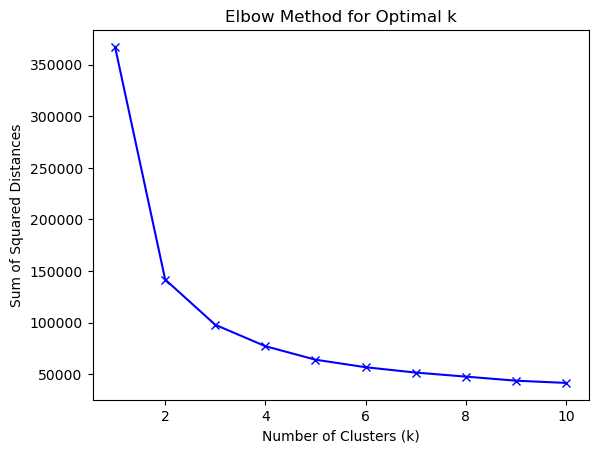

In [12]:
# Define the range of k values
k_values = range(1, 11)  # Example: consider k from 1 to 10

# Initialize an empty list to store the sum of squared distances for each k
sum_of_squared_distances = []

# Fit KMeans models for each value of k and calculate the inertia
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k, n_init=10)
    kmeans.fit(preprocessed_df)
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_values, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

Best k: 2
Best Silhouette Score: 0.5428832671979085


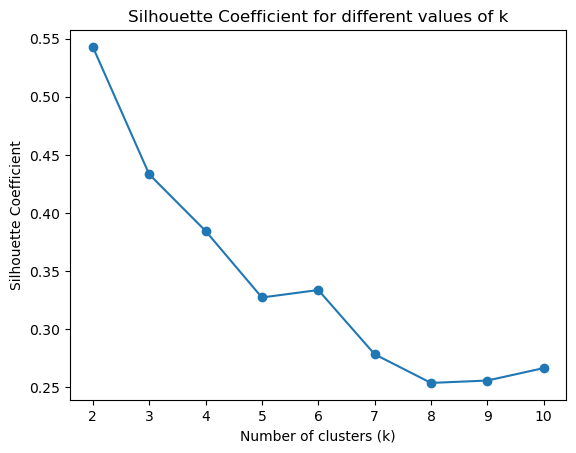

In [13]:

# Define a range of k values to try
k_values = range(2, 11)  # Try k from 2 to 10

# Initialize lists to store Silhouette Coefficients
silhouette_scores = []

# Iterate over each k
for k in k_values:
    # Perform k-Means clustering
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(preprocessed_df)
    
    # Compute Silhouette Coefficient
    silhouette_avg = silhouette_score(preprocessed_df, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Find the best k based on Silhouette Coefficient
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print("Best k:", best_k)
print("Best Silhouette Score:", best_score)

# Plot Silhouette Coefficients
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for different values of k')
plt.show()


[Pipeline] .. (step 1 of 3) Processing education_mapper, total=   0.0s
[Pipeline] ... (step 2 of 3) Processing one_hot_encoder, total=   0.0s
[Pipeline] ..... (step 3 of 3) Processing robust_scaler, total=   0.0s


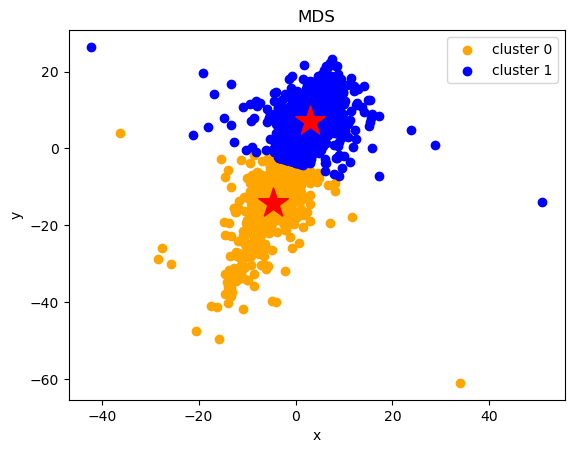

In [19]:
# Set the number of clusters, from the above charts 2 seems best
k = 2

# Run the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

# Fit the pipeline to the data
clustering_model = pipe.fit(df)

# Concatenate the preprocessed data with the cluster centers obtained from k-means
data_and_centers = np.r_[preprocessed_df, clustering_model['kMeans'].cluster_centers_]

# Apply multidimensional scaling (MDS) to reduce the dimensionality of the concatenated data and cluster centers
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)

# Plot the clustering results
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

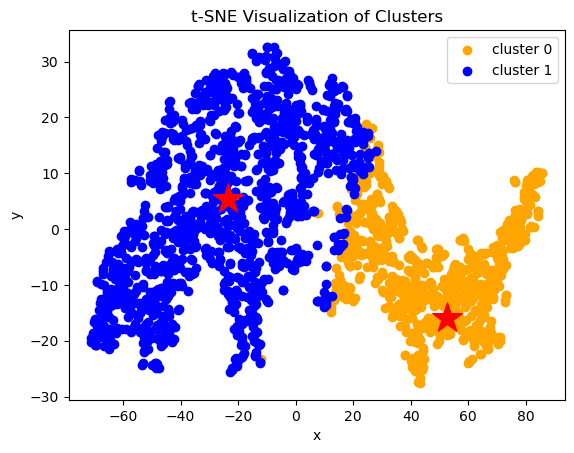

In [20]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensionality of the concatenated data and cluster centers
tsne_coordinates = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(data_and_centers)

# Plot the clustering results using t-SNE
clustering_scatterplot(points=tsne_coordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=tsne_coordinates[-k:,:], 
                       title='t-SNE Visualization of Clusters')

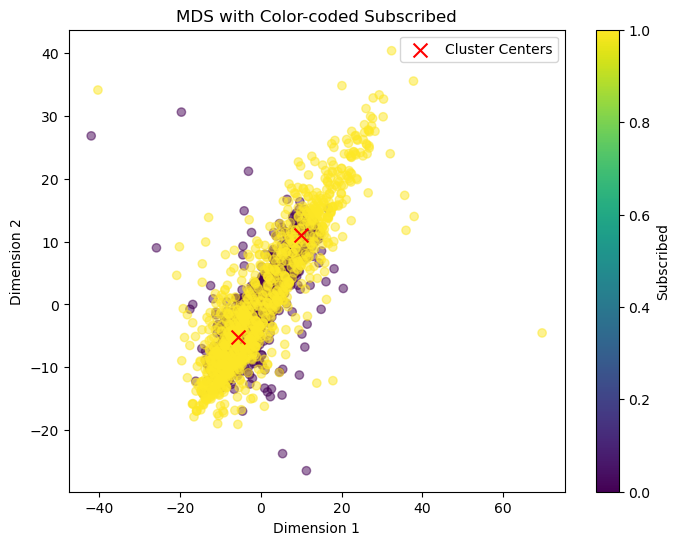

In [16]:
# I am going to produce the same 
def plot_with_target_color(points, labels, centers, target_values, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], c=target_values, cmap='viridis', alpha=0.5)
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=100, c='red', label='Cluster Centers')
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='Subscribed')
    plt.legend()
    plt.show()

# Plot the clustering results with color-coded target values
plot_with_target_color(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       target_values=df['subscribed'], 
                       title='MDS with Color-coded Subscribed')

In [18]:
# Get the total count of members in each cluster
cluster_counts = cluster_df['Cluster'].value_counts()

# Calculate the percentage of subscribed members in each cluster
cluster_sub_percentages = cluster_sub_counts.div(cluster_counts, axis=0) * 100

# Print the percentages
print("Percentage of subscribed members in each cluster:")
print("Cluster 0:", cluster_sub_percentages.loc[0, 1], "%")
print("Cluster 1:", cluster_sub_percentages.loc[1, 1], "%")

Percentage of subscribed members in each cluster:
Cluster 0: 54.54545454545454 %
Cluster 1: 47.64795144157815 %


When using two clusters for a data set with a binary target variable I would hope to see one cluster representing subscribed = yes and the other subscribed = no. In real world use cases it will never be 100% accurate but if there is a material difference between P(target variable = 0/1) then we may have achieved clusters with some predictive power.

In this case we have achieved cluster with 54.5% and 47.5% subscription rates. Ideally the difference between the two would be higher so our bank client could focus their marketing spend on customers who are in the high probability clusters based on their age/education etc. However if the input variables genuinely don't have much predictive power this modelling may still be a good outcome. 

In terms of improving the modelling and making it more useful to the bank: even though duration of contact seems to have some predictive power I think I would remove it. Those who remained on the phone for a lengthier period will have been those interested in the product, those who hung up quite quickly were not good targets to start with. If using this model to decide which customers to target we won't have that information until afterwards anyway. So in pursuit of making the model more useable I would remove duration and see how it performs on the rest of the input variable.

Task 3: DBSCAN

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.
- Use MDS and t-SNE for visualising the clustering. Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

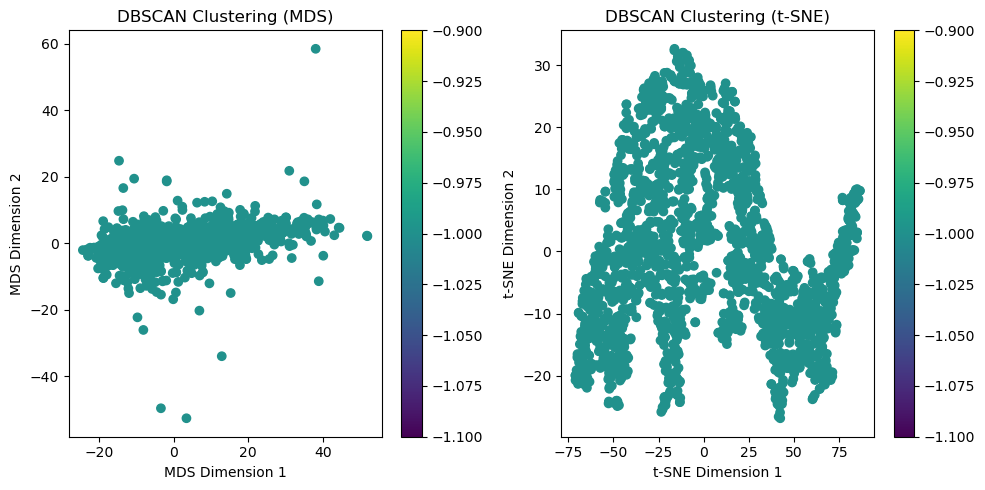

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=5)  # Adjust eps and min_samples as needed
dbscan.fit(preprocessed_df)

# Reduce dimensionality using MDS
mds = MDS(n_components=2, normalized_stress='auto')
XYcoordinates_mds = mds.fit_transform(preprocessed_df)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2)
XYcoordinates_tsne = tsne.fit_transform(preprocessed_df)

# Plot clustering results using MDS
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(XYcoordinates_mds[:, 0], XYcoordinates_mds[:, 1], c=dbscan.labels_, cmap='viridis')
plt.title('DBSCAN Clustering (MDS)')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.colorbar()

# Plot clustering results using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(XYcoordinates_tsne[:, 0], XYcoordinates_tsne[:, 1], c=dbscan.labels_, cmap='viridis')
plt.title('DBSCAN Clustering (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()

plt.tight_layout()
plt.show()

I have tried a wide variety of eps values and simply can't get this to produce two distinct meaningful clusters. Looking at the data visually I also don't see any obvious clustering particularly in the left chart.